# Objetivo del proyecto:

Desarrollar un modelo de detección de fraude transaccional que permita identificar actividades sospechosas y prevenir riesgos financieros para la organización bancaria.

Actividades Realizadas:

- Análisis exploratorio de datos.
- Identificación de anomalías a nivel transaccional.
- Análisis basado en AccountID para detección de patrones anómalos.
- Inserción de datos en base de datos SQL relacional.



## Análisis Exploratorio de Datos

In [92]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


In [93]:
# Cargar los datos y mostrar las primeras filas
df = pd.read_csv(r"C:\Users\Lucas\Desktop\Fraude en transacciones\Data\bank_transactions_data_2.csv")
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [95]:
# Buscamos valores unicos
print("Valores unicos por columna:")
df.nunique()

Valores unicos por columna:


TransactionID              2512
AccountID                   495
TransactionAmount          2455
TransactionDate            2512
TransactionType               2
Location                     43
DeviceID                    681
IP Address                  592
MerchantID                  100
Channel                       3
CustomerAge                  63
CustomerOccupation            4
TransactionDuration         288
LoginAttempts                 5
AccountBalance             2510
PreviousTransactionDate     360
dtype: int64

In [96]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [97]:
# Separar columnas categóricas y numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Categorical Columns: ['TransactionID', 'AccountID', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation', 'PreviousTransactionDate']


In [98]:
# Convertir columnas de fecha a datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verificar valores nulos después de la conversión
print("Valores nulos en TransactionDate:", df['TransactionDate'].isna().sum())
print("Valores nulos en PreviousTransactionDate:", df['PreviousTransactionDate'].isna().sum())

Valores nulos en TransactionDate: 0
Valores nulos en PreviousTransactionDate: 0


## Extracción de Características de las columnas de Fecha:
- Hora del día: Extrae la hora y el minuto de la fecha de transacción.
- Día de la Semana: Determine si una transacción ocurrió en un día laborable o fin de semana.
- Semana del Año: Identifica la semana en la que se produjo la transacción.

In [99]:
# Extraer Año, Mes y Día
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

# Día de la Semana
df['TransactionWeekday'] = df['TransactionDate'].dt.weekday

df['DaysSinceLastTransaction'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.days


In [100]:
df.info

<bound method DataFrame.info of      TransactionID AccountID  TransactionAmount     TransactionDate  \
0         TX000001   AC00128              14.09 2023-04-11 16:29:14   
1         TX000002   AC00455             376.24 2023-06-27 16:44:19   
2         TX000003   AC00019             126.29 2023-07-10 18:16:08   
3         TX000004   AC00070             184.50 2023-05-05 16:32:11   
4         TX000005   AC00411              13.45 2023-10-16 17:51:24   
...            ...       ...                ...                 ...   
2507      TX002508   AC00297             856.21 2023-04-26 17:09:36   
2508      TX002509   AC00322             251.54 2023-03-22 17:36:48   
2509      TX002510   AC00095              28.63 2023-08-21 17:08:50   
2510      TX002511   AC00118             185.97 2023-02-24 16:24:46   
2511      TX002512   AC00009             243.08 2023-02-14 16:21:23   

     TransactionType          Location DeviceID      IP Address MerchantID  \
0              Debit         San Dieg

In [102]:
# Lista de columnas categóricas
categorical_columns = ['TransactionID', 'AccountID', 'TransactionType', 
                      'Location', 'DeviceID', 'IP Address', 'MerchantID', 
                      'Channel', 'CustomerOccupation', 'PreviousTransactionDate']

for column in categorical_columns:
    print(f"Valores únicos en la columna '{column}':")
    print(df[column].unique())
    print("\n")

# Agrega otras columnas categóricas si las necesitas
categorical_columns += ['TransactionMonth', 'TransactionDay', 
                        'TransactionWeekday']

for column in categorical_columns:
    print(f"Valores únicos en la columna '{column}':")
    print(df[column].unique())
    print("\n")

# Agrega otras columnas no categóricas si las necesitas
numerical_columns = ['CustomerAge', 'TransactionAmount', 
                     'LoginAttempts', 'AccountBalance']

for column in numerical_columns:
    print(f"Desvío y media de la columna '{column}':")
    print(df[column].describe())
    print("\n")

# Agrega otras columnas si las necesitas
other_columns = ['TransactionDuration']

for column in other_columns:
    print(f"Min, max y promedio de la columna '{column}':")
    print(df[column].describe())
    print("\n")

Valores únicos en la columna 'TransactionID':
['TX000001' 'TX000002' 'TX000003' ... 'TX002510' 'TX002511' 'TX002512']


Valores únicos en la columna 'AccountID':
['AC00128' 'AC00455' 'AC00019' 'AC00070' 'AC00411' 'AC00393' 'AC00199'
 'AC00069' 'AC00135' 'AC00385' 'AC00150' 'AC00459' 'AC00392' 'AC00264'
 'AC00085' 'AC00270' 'AC00317' 'AC00359' 'AC00242' 'AC00285' 'AC00002'
 'AC00014' 'AC00095' 'AC00453' 'AC00241' 'AC00041' 'AC00441' 'AC00057'
 'AC00390' 'AC00313' 'AC00367' 'AC00291' 'AC00060' 'AC00365' 'AC00267'
 'AC00404' 'AC00202' 'AC00478' 'AC00405' 'AC00421' 'AC00480' 'AC00120'
 'AC00117' 'AC00011' 'AC00401' 'AC00282' 'AC00439' 'AC00296' 'AC00471'
 'AC00159' 'AC00482' 'AC00115' 'AC00055' 'AC00419' 'AC00374' 'AC00271'
 'AC00456' 'AC00143' 'AC00427' 'AC00438' 'AC00425' 'AC00325' 'AC00434'
 'AC00319' 'AC00460' 'AC00461' 'AC00395' 'AC00217' 'AC00053' 'AC00110'
 'AC00265' 'AC00239' 'AC00007' 'AC00022' 'AC00464' 'AC00406' 'AC00445'
 'AC00236' 'AC00220' 'AC00140' 'AC00098' 'AC00303' 'AC003

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18268\1854578162.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=all_locations.index, x=all_locations.values, palette='bright')


Text(0, 0.5, 'Location')

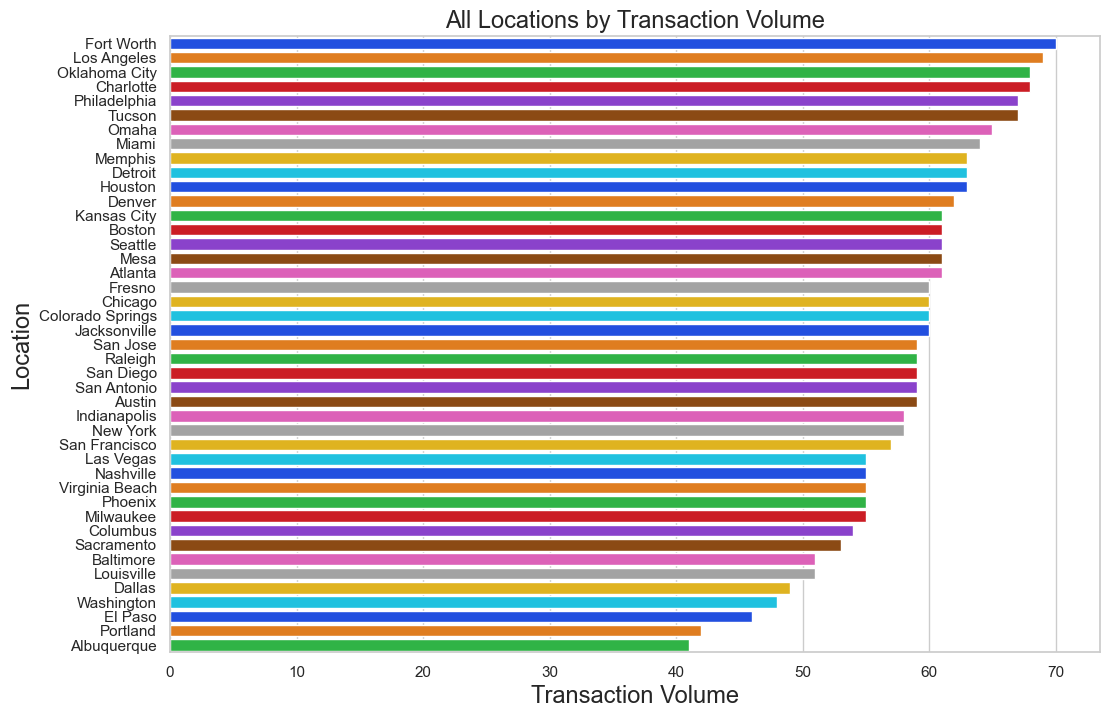

In [103]:
# Obtenir las 43 locations con mayor volumen de transaccions
all_locations = df['Location'].value_counts().head(43)

plt.figure(figsize=(12,8))
sns.barplot(y=all_locations.index, x=all_locations.values, palette='bright')
plt.title('All Locations by Transaction Volume', fontsize=17)
plt.xlabel('Transaction Volume', fontsize=17)
plt.ylabel('Location', fontsize=17)

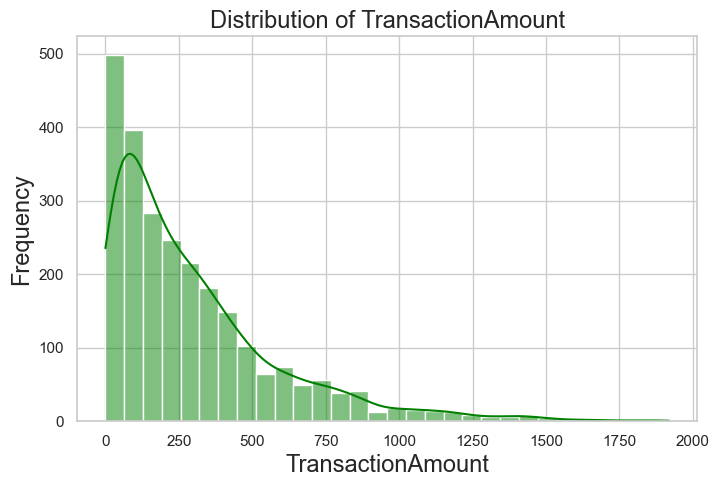

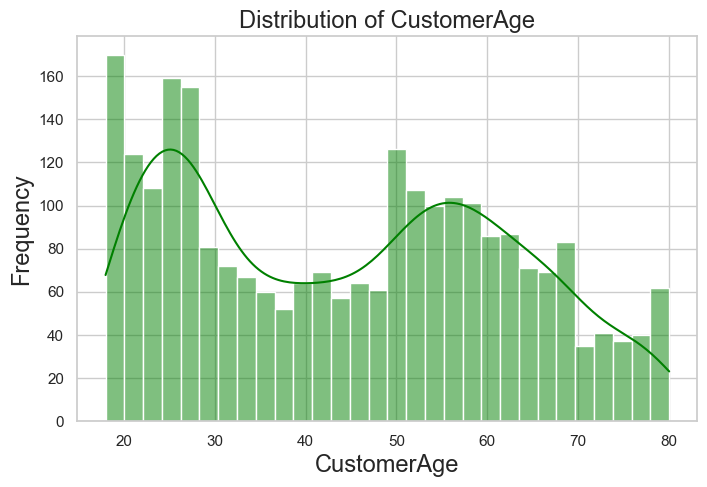

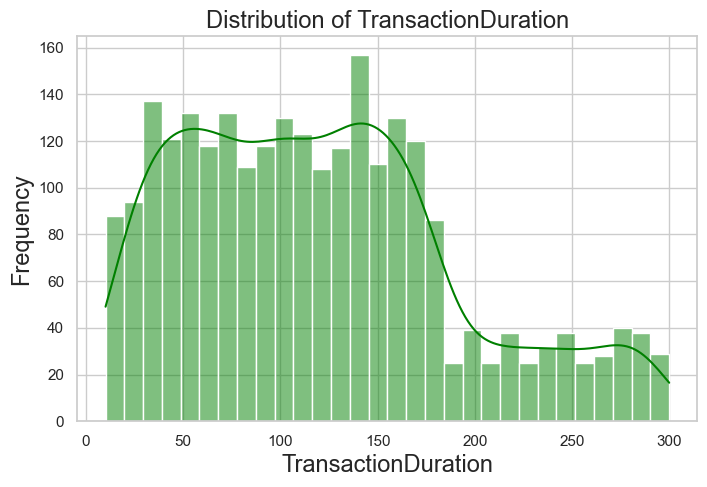

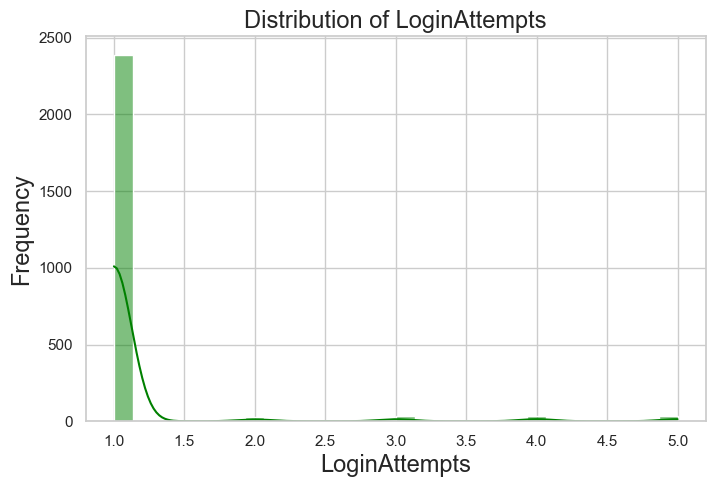

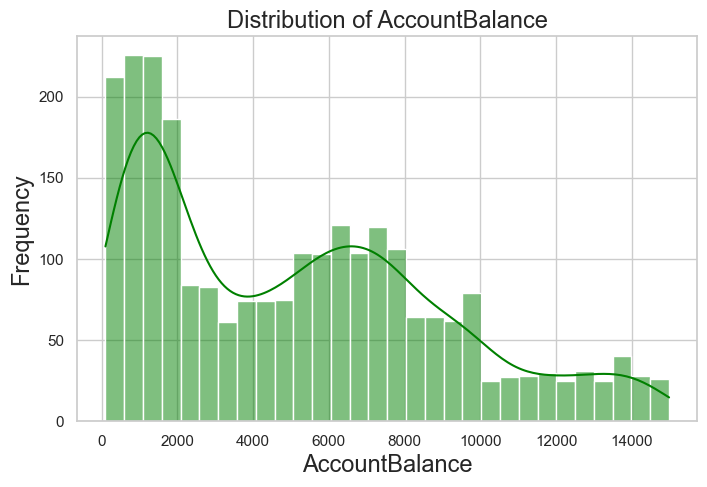

In [104]:
# Función para plotear gráficos de historgramas por columnas numéricas
def plot_histograms(df, numerical_columns):
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        # Create a histogram with KDE
        sns.histplot(df[column], bins=30, kde=True, color='green')  
        plt.title(f'Distribution of {column}', fontsize=17)
        plt.xlabel(column, fontsize=17)
        plt.ylabel('Frequency', fontsize=17)
        plt.show()

# Define las columnas numéricas a visualizar
numerical_columns = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

plot_histograms(df, numerical_columns)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18268\3936631244.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='TransactionType', palette='bright')


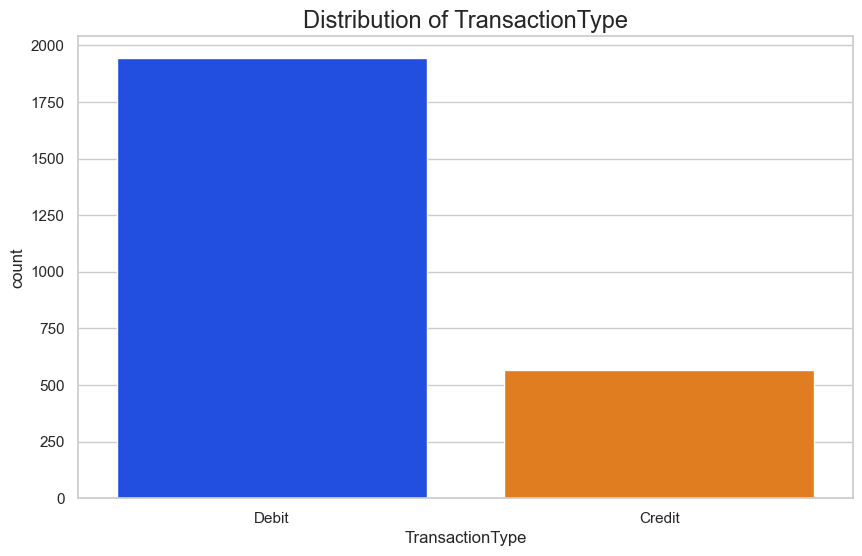

In [105]:
# Distribución de tipos de transacciones (Debit o Crédito)
# Cuenta los registros con tipo de transacción 'Debit' y 'Credit'
debitcard_counts = df[df['TransactionType']=='Debit']['TransactionType'].count()
creditcard_counts = df[df['TransactionType']=='Credit']['TransactionType'].count()

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='TransactionType', palette='bright')
plt.title('Distribution of TransactionType', fontsize=17)
plt.show()

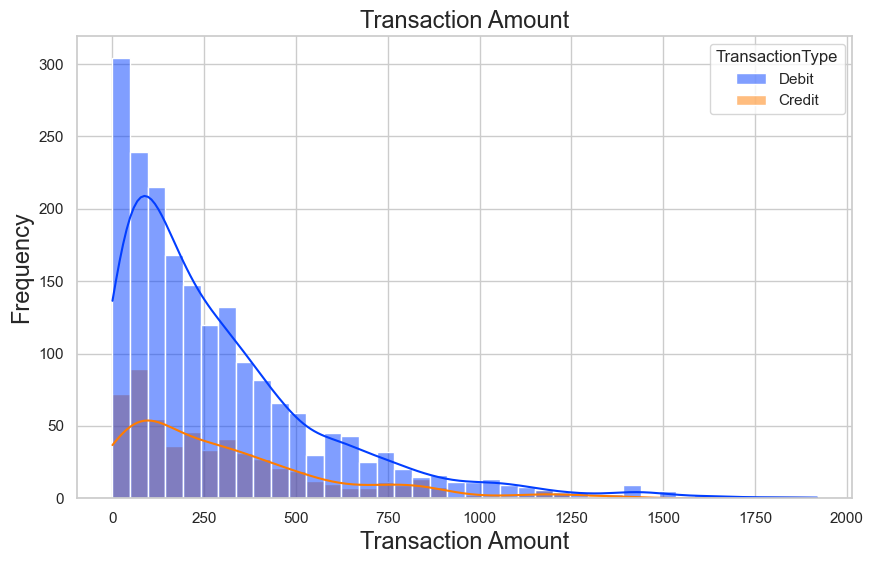

In [106]:
# Distribución de la cantidad transaccional
plt.figure(figsize=(10,6))
plt.xlabel("Transaction Amount", fontsize=17)
plt.ylabel("Frequency", fontsize=17)
plt.title("Transaction Amount", fontsize=17)
sns.histplot(data=df, x="TransactionAmount", kde=True, hue='TransactionType', palette='bright')
plt.show()

868 833 811


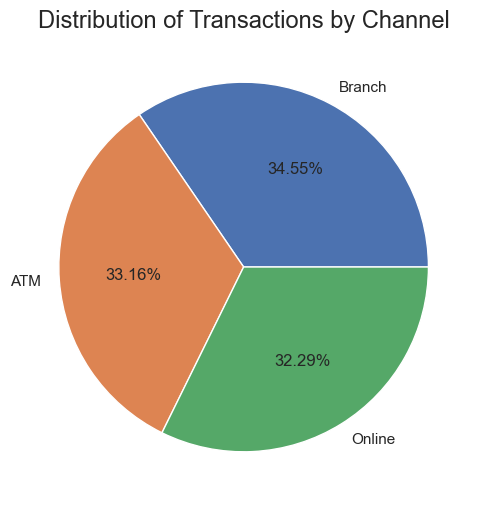

In [107]:
# Plota la distribución de transacciones según el canal ATM, sucursal y línea online
# Cuenta los registros por cada tipo de canal (ATM, sucursal y línea online)
branch_counts = df[df['Channel']=='Branch']['Channel'].count()
atm_counts = df[df['Channel']=='ATM']['Channel'].count()
online_counts = df[df['Channel']=='Online']['Channel'].count()

# Imprime los valores contados en la pantalla
print(branch_counts, atm_counts, online_counts)

plt.figure(figsize=(10, 6))
# Define las etiquetas de los valores a utilizar en el gráfico
index_values = [branch_counts, atm_counts, online_counts]
index_labels = ['Branch', 'ATM', 'Online']
plt.pie(index_values, labels = index_labels, autopct='%2.2f%%')
plt.title('Distribution of Transactions by Channel', fontsize=17)
plt.show()

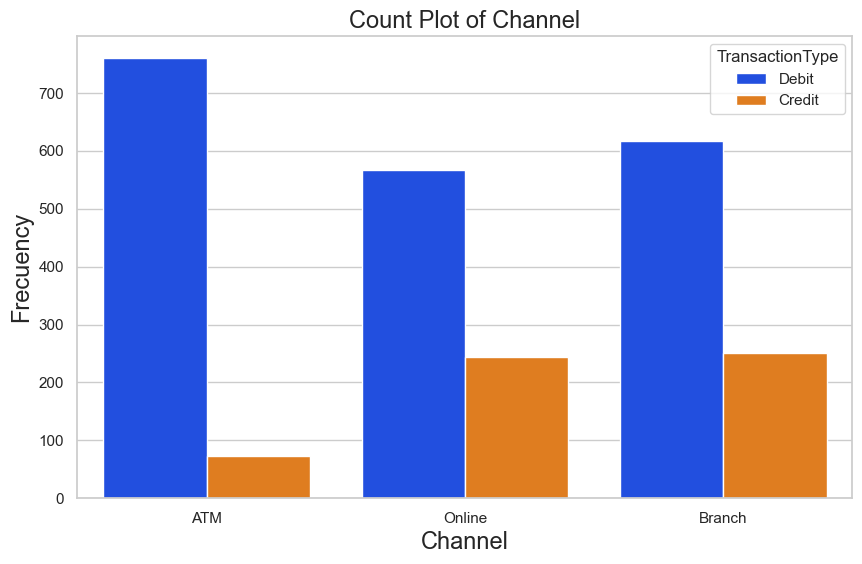

In [108]:
# Crea una figura para mostrar el gráfico de conteo por canal y typo
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Channel', hue='TransactionType', palette='bright')
plt.xlabel('Channel', fontsize=17)
plt.ylabel('Frecuency', fontsize=17)
plt.title('Count Plot of Channel', fontsize=17)
plt.show()

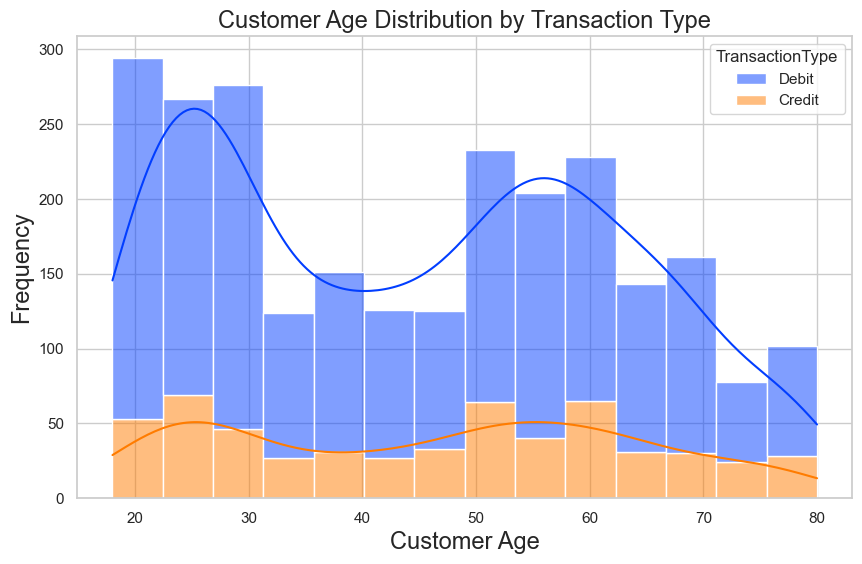

In [109]:
# Crea una figura para mostrar la distribución de la edad del cliente según el tipo de transacción
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='CustomerAge', hue='TransactionType', multiple='stack', palette='bright', kde=True)
plt.title('Customer Age Distribution by Transaction Type', fontsize=17)
plt.xlabel('Customer Age',fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.show()

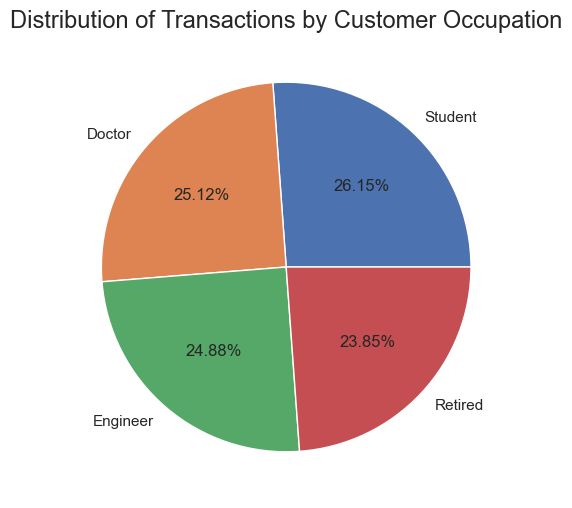

In [110]:
# Cuenta los registros por ocupación del cliente
student_counts = df[df['CustomerOccupation']=='Student']['CustomerOccupation'].count()
doctor_counts = df[df['CustomerOccupation']=='Doctor']['CustomerOccupation'].count()
engineer_counts = df[df['CustomerOccupation']=='Engineer']['CustomerOccupation'].count()
retired_counts = df[df['CustomerOccupation']=='Retired']['CustomerOccupation'].count()

plt.figure(figsize=(10,6))

index_values = [student_counts, doctor_counts, engineer_counts, retired_counts]
index_labels = ['Student', 'Doctor', 'Engineer', 'Retired']

plt.pie(index_values, labels = index_labels, autopct='%2.2f%%')

plt.title('Distribution of Transactions by Customer Occupation', fontsize=17)

plt.show()

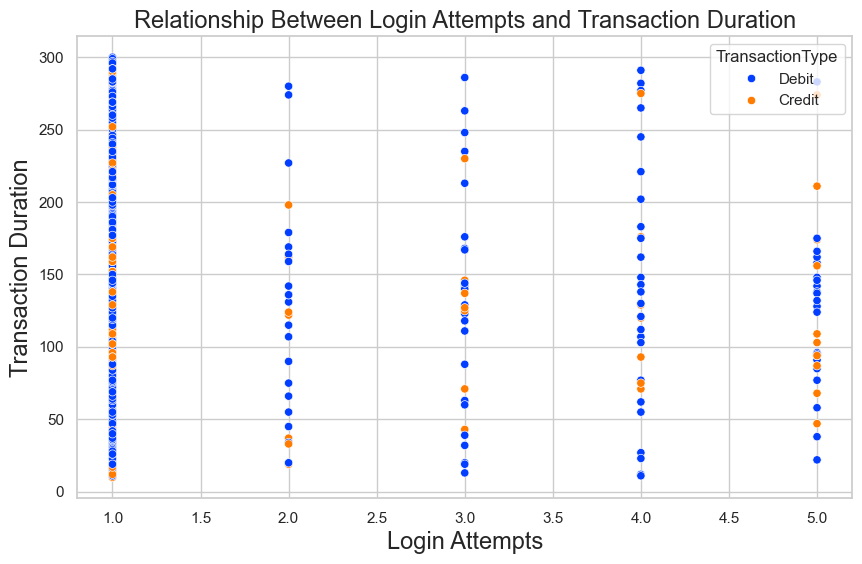

In [111]:
# Crea una figura para mostrar la relación entre intentos de inicio de sesión y duración de transacciones
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LoginAttempts', y='TransactionDuration', hue='TransactionType', palette='bright')
plt.title('Relationship Between Login Attempts and Transaction Duration', fontsize=17)
plt.xlabel('Login Attempts', fontsize=17)
plt.ylabel('Transaction Duration', fontsize=17)
plt.show()

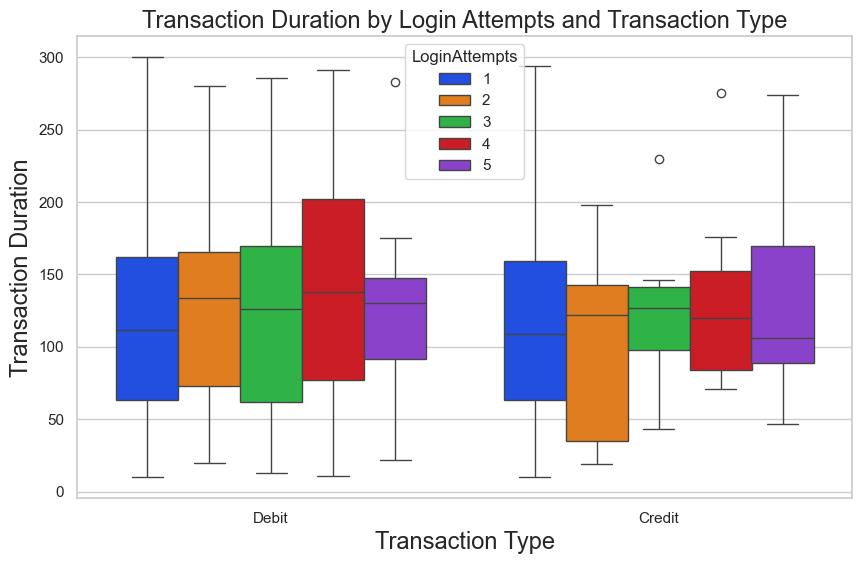

In [112]:
# Crea una figura para mostrar la duración de transacciones según los intentos de inicio de sesión y el tipo de transacción
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='TransactionType', y='TransactionDuration', hue='LoginAttempts', palette='bright')
plt.title('Transaction Duration by Login Attempts and Transaction Type', fontsize=17)
plt.xlabel('Transaction Type', fontsize=17)
plt.ylabel('Transaction Duration', fontsize=17)
plt.show()

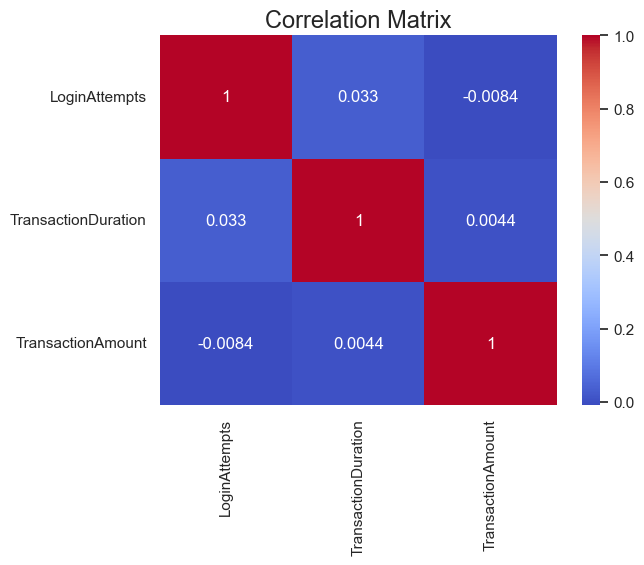

In [113]:
# Crea una matriz de correlación para las variables seleccionadas
correlation_matrix = df[['LoginAttempts', 'TransactionDuration', 'TransactionAmount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=17)
plt.show()

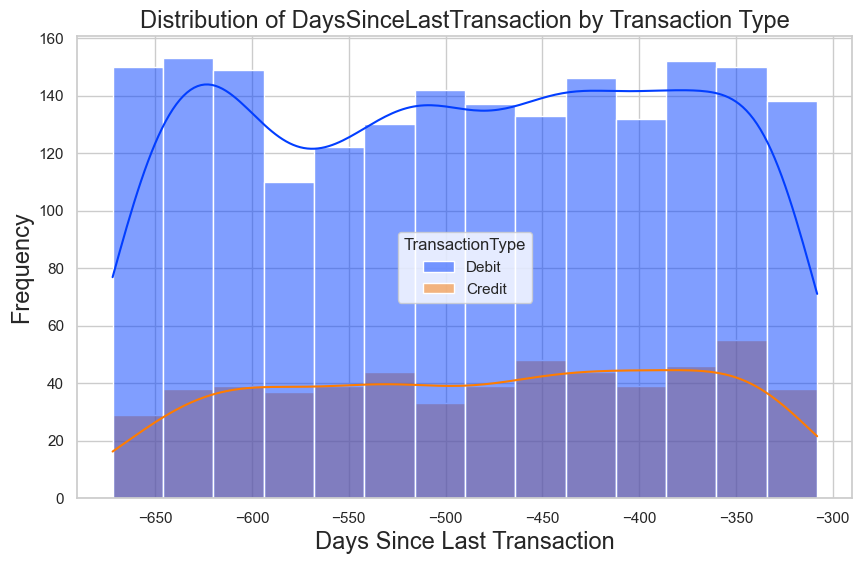

In [114]:
# Crea un gráfico para representar la distribución de los días desde la última transacción por tipo de transacción
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DaysSinceLastTransaction', kde=True, hue='TransactionType', palette='bright')
plt.title('Distribution of DaysSinceLastTransaction by Transaction Type', fontsize=17)
plt.xlabel('Days Since Last Transaction', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.show()

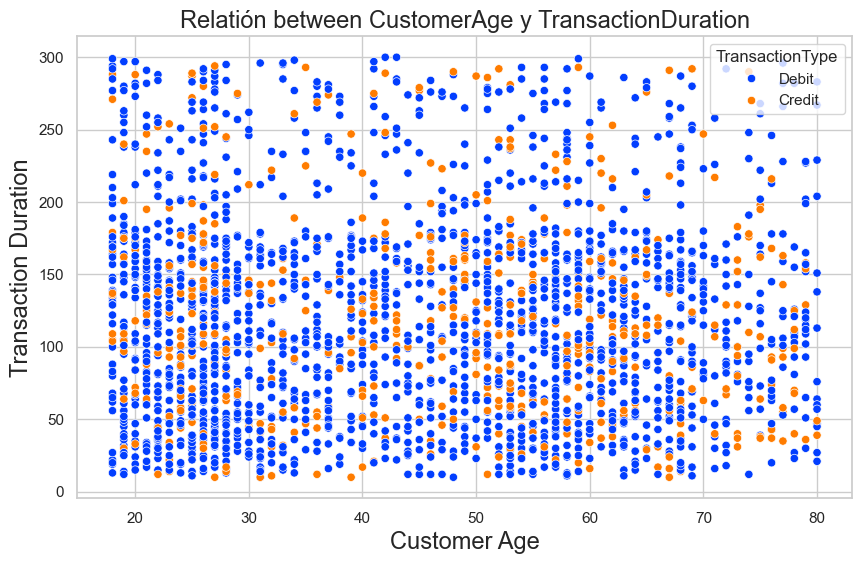

In [158]:
# Crea una figura para mostrar la relación entre la edad del cliente y la duración de las transacciones según el tipo de transacción
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='CustomerAge', y='TransactionDuration', hue='TransactionType', palette='bright')
plt.title('Relatión between CustomerAge y TransactionDuration', fontsize=17)
plt.xlabel('Customer Age', fontsize=17)
plt.ylabel('Transaction Duration', fontsize=17)
plt.show()

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TransactionID             2512 non-null   object        
 1   AccountID                 2512 non-null   object        
 2   TransactionAmount         2512 non-null   float64       
 3   TransactionDate           2512 non-null   datetime64[ns]
 4   TransactionType           2512 non-null   object        
 5   Location                  2512 non-null   object        
 6   DeviceID                  2512 non-null   object        
 7   IP Address                2512 non-null   object        
 8   MerchantID                2512 non-null   object        
 9   Channel                   2512 non-null   object        
 10  CustomerAge               2512 non-null   int64         
 11  CustomerOccupation        2512 non-null   object        
 12  TransactionDuration 

# Identificación de Anomalías a Nivel de TransacciónID

Este análisis se enfoca en identificar patrones anómalos en transacciones individuales utilizando el modelo **Isolation Forest**. 

### Objetivos:
1. Detectar transacciones que presentan comportamientos atípicos considerando variables clave.
2. Analizar si estas transacciones atípicas están asociadas a cuentas específicas o eventos inusuales.
3. Proporcionar información valiosa para la detección de fraudes, errores o comportamientos fuera de la norma.

### Variables Analizadas:
- **TransactionAmount**: Monto de la transacción.
- **CustomerAge**: Edad del cliente.
- **TransactionDuration**: Duración de la transacción.
- **LoginAttempts**: Intentos de inicio de sesión relacionados.
- **AccountBalance**: Saldo disponible en la cuenta.
- **DaysSinceLastTransaction**: Días transcurridos desde la última transacción.

El modelo clasifica las transacciones como:
- **1**: Transacción normal.
- **-1**: Transacción anómala.

## Preparación de Datos

Antes de entrenar el modelo, se seleccionaron las columnas relevantes para el análisis, asegurando que todas sean variables numéricas y relacionadas con el comportamiento de las transacciones:

### Variables seleccionadas:
1. `TransactionAmount`: Representa el monto de cada transacción.
2. `CustomerAge`: Ayuda a entender posibles anomalías relacionadas con perfiles de edad.
3. `TransactionDuration`: Captura variabilidad en la duración de transacciones.
4. `LoginAttempts`: Indica posibles intentos repetidos de autenticación.
5. `AccountBalance`: Saldo disponible para la transacción.
6. `DaysSinceLastTransaction`: Factor de tiempo que puede influir en la frecuencia de transacciones.

In [116]:
# Selección de columnas numéricas
numerical_columns = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 
                     'LoginAttempts', 'AccountBalance', 'DaysSinceLastTransaction']


In [117]:
# Crear un DataFrame con las variables numéricas relevantes, AccountID y TransactionID
df_numerical = df[['TransactionAmount', 'CustomerAge', 'TransactionDuration', 
                   'LoginAttempts', 'AccountBalance', 'DaysSinceLastTransaction',
                   'TransactionID', 'AccountID']]

## Entrenamiento del Modelo Isolation Forest

Se utilizó el modelo **Isolation Forest** para identificar transacciones anómalas. Este modelo es particularmente efectivo para detectar comportamientos atípicos, ya que no requiere un conjunto etiquetado de datos y puede manejar grandes volúmenes de información.

### Parámetros principales:
- **n_estimators**: 100 (número de árboles en el bosque).
- **contamination**: 0.05 (el 5% de las transacciones se consideran anómalas).
- **random_state**: 42 (para reproducibilidad).

El modelo evalúa cada transacción en función de las variables numéricas seleccionadas y asigna una etiqueta:
- **1**: Transacción considerada normal.
- **-1**: Transacción identificada como anómala.

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_numerical['Anomaly'] = iso_forest.fit_predict(df_numerical[['TransactionAmount', 'CustomerAge', 
                                                                     'TransactionDuration', 
                                                                     'LoginAttempts', 
                                                                     'AccountBalance', 
                                                                     'DaysSinceLastTransaction']])

In [119]:
anomalies = df_numerical[df_numerical['Anomaly'] == -1]
print(anomalies)

      TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
26               246.93           23                  158              5   
32               396.45           49                  168              3   
74              1212.51           20                   24              1   
85              1340.19           54                   30              1   
141             1049.92           80                   21              1   
...                 ...          ...                  ...            ...   
2403            1493.00           69                  151              1   
2414            1664.33           18                   65              1   
2423             332.06           29                  221              4   
2445             403.01           63                  286              3   
2457              79.92           44                  274              2   

      AccountBalance  DaysSinceLastTransaction TransactionID AccountID  \
26           

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18268\3972541946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical['AnomalyColor'] = df_numerical['Anomaly'].map({1: 'Normal', -1: 'Anomalía'})


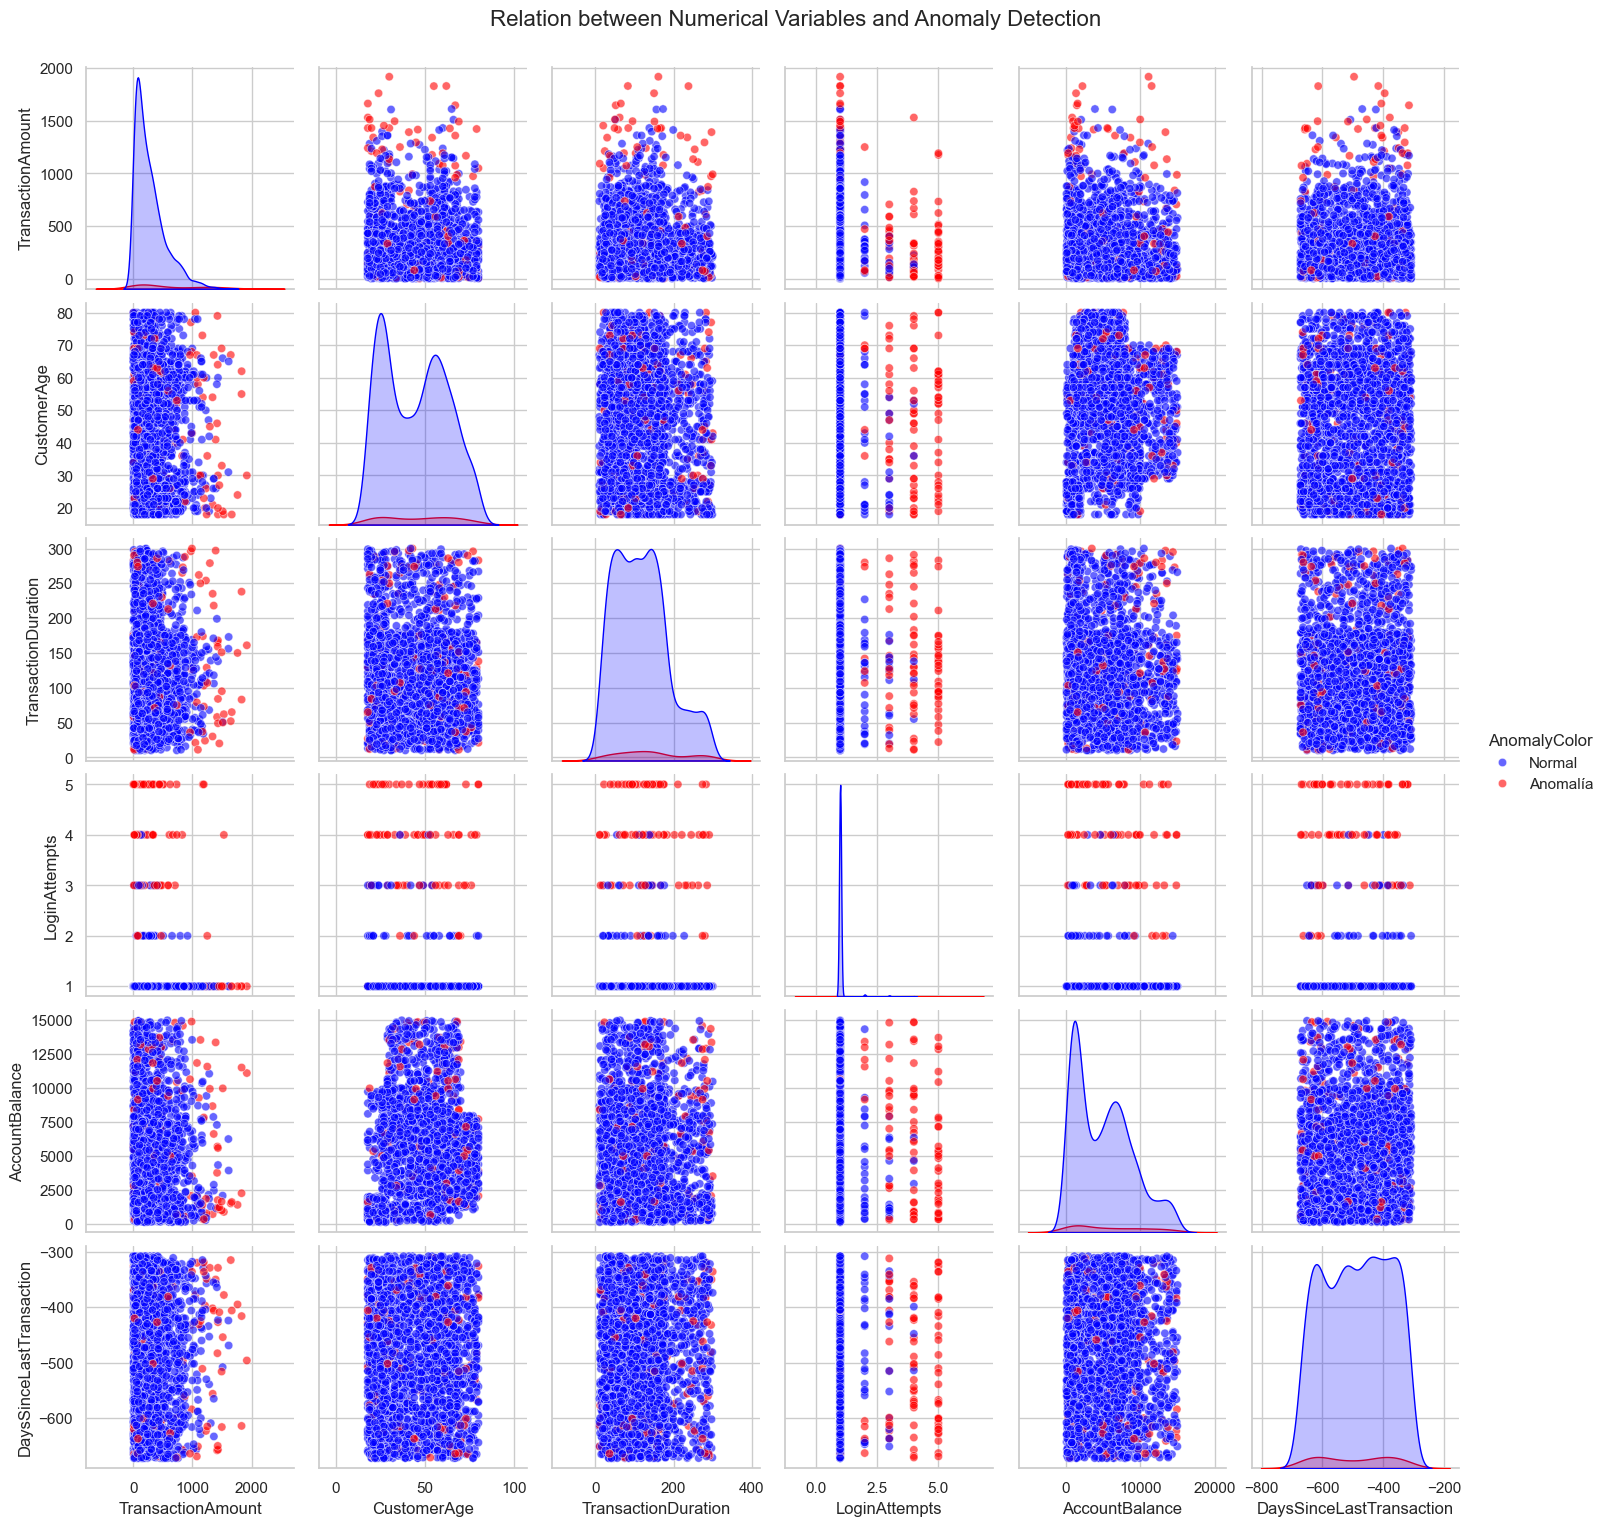

In [159]:
# Asignar colores a transacciones normales y anómalas
df_numerical['AnomalyColor'] = df_numerical['Anomaly'].map({1: 'Normal', -1: 'Anomalía'})

# Crear un Pairplot para explorar relaciones entre variables numéricas
sns.pairplot(
    df_numerical,
    vars=['TransactionAmount', 'CustomerAge', 'TransactionDuration', 
          'LoginAttempts', 'AccountBalance', 'DaysSinceLastTransaction'],
    hue='AnomalyColor',  # Colorear según anomalías
    palette={'Normal': 'blue', 'Anomalía': 'red'},
    plot_kws={'alpha': 0.6}  # Transparencia de los puntos
)

plt.suptitle('Relation between Numerical Variables and Anomaly Detection', y=1.02, fontsize=16)
plt.show()

## Resumen de Anomalías Detectadas

El modelo identificó un total de **126 transacciones** como anómalas. Estas transacciones representan el 5% del total analizado, en línea con el parámetro `contamination`.

### Principales hallazgos:
- **Variabilidad en los montos**: Los montos de las transacciones anómalas varían considerablemente, desde valores muy bajos hasta extremadamente altos.
- **Distribución por cuentas**: Algunas cuentas tienen múltiples transacciones anómalas, lo que puede indicar patrones de comportamiento sospechoso.
- **Edad de los clientes**: Las anomalías están asociadas con un rango diverso de edades, lo que sugiere que no se limitan a un grupo demográfico específico.

In [121]:
account_anomalies = anomalies['AccountID'].value_counts()
print(account_anomalies[account_anomalies > 1])

AccountID
AC00071    3
AC00358    3
AC00316    2
AC00418    2
AC00465    2
AC00039    2
AC00385    2
AC00336    2
AC00149    2
AC00228    2
AC00018    2
Name: count, dtype: int64


In [149]:
# Crear un nuevo DataFrame con las variables numéricas relevantes y la columna 'Anomaly'
anomalies_numerical = df[['TransactionAmount', 'CustomerAge',
                           'TransactionDuration', 'LoginAttempts',
                           'AccountBalance', 'DaysSinceLastTransaction']]

# Entrenar el modelo Isolation Forest
iso_forest.fit(anomalies_numerical)

# Obtener las predicciones de anomalías para cada fila
anomaly_predictions = iso_forest.predict(anomalies_numerical)

# Crear una serie con las predicciones de anomalías y agregarla al dataframe original
df['Anomaly'] = pd.Series(anomaly_predictions, index=df.index)

# Verificar si hay anomalías
print(df[df['Anomaly'] == -1])

     TransactionID AccountID  TransactionAmount     TransactionDate  \
26        TX000027   AC00441             246.93 2023-04-17 16:37:01   
32        TX000033   AC00060             396.45 2023-09-25 16:26:00   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
85        TX000086   AC00098            1340.19 2023-09-29 17:22:10   
141       TX000142   AC00114            1049.92 2023-10-23 16:50:33   
...            ...       ...                ...                 ...   
2403      TX002404   AC00111            1493.00 2023-06-07 17:05:41   
2414      TX002415   AC00028            1664.33 2023-09-25 17:11:19   
2423      TX002424   AC00340             332.06 2023-06-21 16:38:54   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
2457      TX002458   AC00315              79.92 2023-02-06 17:32:11   

     TransactionType          Location DeviceID       IP Address MerchantID  \
26             Debit             Miami  D000046   55.154.161.250    

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TransactionID             2512 non-null   object        
 1   AccountID                 2512 non-null   object        
 2   TransactionAmount         2512 non-null   float64       
 3   TransactionDate           2512 non-null   datetime64[ns]
 4   TransactionType           2512 non-null   object        
 5   Location                  2512 non-null   object        
 6   DeviceID                  2512 non-null   object        
 7   IP Address                2512 non-null   object        
 8   MerchantID                2512 non-null   object        
 9   Channel                   2512 non-null   object        
 10  CustomerAge               2512 non-null   int64         
 11  CustomerOccupation        2512 non-null   object        
 12  TransactionDuration 

### Guardamos el dataframe en un archivo cvs para su posterior importacion en la Base de Datos

In [ ]:
# Ruta del archivo
ruta_guardado = r'C:\Users\Lucas\Desktop\Fraude en transacciones\Data'

# Crear directorio si no existe
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)

# Nombre del archivo a guardar
archivo = 'transacciones.csv'

# Ruta completa del archivo
ruta_archivo = os.path.join(ruta_guardado, archivo)

# Guardar el CSV en la ruta especificada
df.to_csv(ruta_archivo, index=False)

# Verificar si el archivo se ha guardado correctamente
print(f"Archivo '{archivo}' guardado con éxito en {ruta_guardado}")

Archivo 'transacciones.csv' guardado con éxito en C:\Users\Lucas\Desktop\Fraude en transacciones\Data


In [156]:
df = pd.read_csv(r"C:\Users\Lucas\Desktop\Fraude en transacciones\Data\transacciones.csv")
print(df.head())
print(df.info())

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  ...  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM  ...   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM  ...   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online  ...   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online  ...   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online  ...   

   TransactionDuration LoginAttempts  AccountBalance  PreviousTransactionDate  \
0                

## Análisis Basado en AccountID para Detección de Patrones Anómalos

El análisis se centra en detectar patrones anómalos a nivel de cuentas específicas (AccountID), en lugar de identificar anomalías en transacciones individuales. Este enfoque es especialmente efectivo para evaluar comportamientos generales, detectar posibles fraudes, abusos, o identificar errores sistémicos asociados a cuentas completas.

## Motivación para Agrupar por AccountID

### Razones principales:
- **Visión Global**: Aunque cada transacción puede parecer legítima de manera individual, el análisis agregado por `AccountID` permite identificar comportamientos anómalos generales.
- **Patrones Clave Detectados**:
  - Volúmenes desproporcionados de transacciones.
  - Valores extremos en montos totales o promedios.
  - Variabilidad inusual en la duración de transacciones.
  - Frecuencia anormal de intentos de inicio de sesión.

### Beneficios:
- Proporciona una visión más relevante para la prevención de fraudes o identificación de conductas inusuales.
- Permite clasificar cuentas sospechosas basadas en su comportamiento global, reduciendo el ruido causado por transacciones individuales aisladas.


In [122]:
grouped_data = df.groupby('AccountID').agg({
    'TransactionAmount': ['sum', 'mean', 'std'],
    'TransactionDuration': ['mean', 'std'],
    'LoginAttempts': 'sum',
    'DaysSinceLastTransaction': 'mean'
}).reset_index()
# Renombrar las columnas para mayor claridad
grouped_data.columns = [
    'AccountID', 'TotalTransactionAmount', 'AvgTransactionAmount', 
    'StdTransactionAmount', 'AvgTransactionDuration', 'StdTransactionDuration', 
    'TotalLoginAttempts', 'AvgDaysSinceLastTransaction'
]

## Transformación de Datos

Se agruparon los datos por `AccountID` para calcular métricas clave que describen el comportamiento de cada cuenta, tales como:

- **TotalTransactionAmount**: Suma de los montos de las transacciones.
- **AvgTransactionAmount**: Promedio de los montos de las transacciones.
- **StdTransactionAmount**: Desviación estándar de los montos de las transacciones.
- **AvgTransactionDuration**: Duración promedio de las transacciones.
- **StdTransactionDuration**: Variabilidad en la duración de las transacciones.
- **TotalLoginAttempts**: Número total de intentos de inicio de sesión.
- **AvgDaysSinceLastTransaction**: Promedio de días desde la última transacción.

Además, se manejaron valores nulos en las desviaciones estándar, ya que algunas cuentas tienen una única transacción.


In [142]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AccountID                    495 non-null    object 
 1   TotalTransactionAmount       495 non-null    float64
 2   AvgTransactionAmount         495 non-null    float64
 3   StdTransactionAmount         495 non-null    float64
 4   AvgTransactionDuration       495 non-null    float64
 5   StdTransactionDuration       495 non-null    float64
 6   TotalLoginAttempts           495 non-null    int64  
 7   AvgDaysSinceLastTransaction  495 non-null    float64
 8   Anomaly                      495 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 34.9+ KB


Se manejan valores nulos en las desviaciones estándar, debido a cuentas con una sola transacción.

In [143]:
# Rellenar NaN con 0 en las columnas afectadas
grouped_data['StdTransactionAmount'].fillna(0, inplace=True)
grouped_data['StdTransactionDuration'].fillna(0, inplace=True)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18268\2140506625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grouped_data['StdTransactionAmount'].fillna(0, inplace=True)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_18268\2140506625.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

## Identificación de Anomalías

Se utilizó un modelo de **Isolation Forest** para detectar patrones de comportamiento inusuales a nivel de cuenta. Las características utilizadas para el modelo son:

- **TotalTransactionAmount**
- **AvgTransactionAmount**
- **StdTransactionAmount**
- **AvgTransactionDuration**
- **StdTransactionDuration**
- **TotalLoginAttempts**
- **nAvgDaysSinceLastTransactio**

El modelo clasifica las cuentas como:
- **1**: Comportamiento normal.
- **-1**: Comportamiento anómalo.


In [144]:
# Seleccionar las variables relevantes para el modelo
features = ['TotalTransactionAmount', 'AvgTransactionAmount', 
            'StdTransactionAmount', 'AvgTransactionDuration', 
            'StdTransactionDuration', 'TotalLoginAttempts', 
            'AvgDaysSinceLastTransaction']

# Configurar y entrenar el modelo
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
grouped_data['Anomaly'] = iso_forest.fit_predict(grouped_data[features])

# Identificar cuentas anómalas
anomalies = grouped_data[grouped_data['Anomaly'] == -1]
print(anomalies)

    AccountID  TotalTransactionAmount  AvgTransactionAmount  \
27    AC00028                 2170.17            723.390000   
42    AC00044                  487.32            487.320000   
47    AC00049                 1113.77            556.885000   
69    AC00071                 4050.12            506.265000   
144   AC00146                 1171.78            585.890000   
161   AC00163                  615.91            307.955000   
166   AC00168                   77.83             77.830000   
177   AC00179                 3819.73            636.621667   
178   AC00180                  108.96            108.960000   
184   AC00186                  456.83            228.415000   
197   AC00199                    7.08              7.080000   
248   AC00252                 1501.57            750.785000   
279   AC00283                   77.90             77.900000   
305   AC00309                   52.04             52.040000   
308   AC00312                 1958.92            489.73

### Relación entre Total y Promedio de Montos de Transacciones

- **Descripción**: Muestra la relación entre el monto total y el promedio de las transacciones.
- **Interpretación**:
  - Los puntos representan las cuentas.
  - El tamaño de los puntos refleja la desviación estándar del monto de las transacciones, indicando la variabilidad.


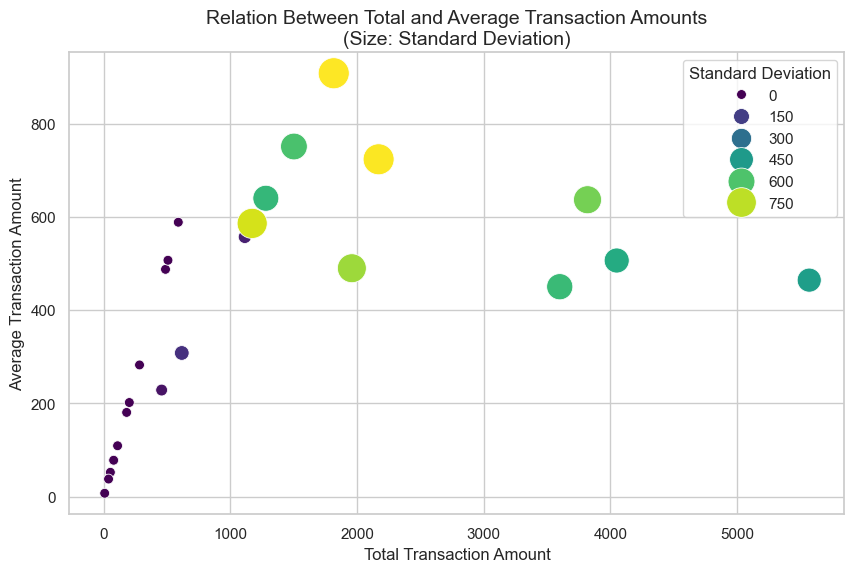

In [163]:
# Configuración general de los gráficos
sns.set(style="whitegrid", context="notebook")

# TotalTransactionAmount vs AvgTransactionAmount, con StdTransactionAmount como color
plt.figure(figsize=(10, 6))
scatter1 = sns.scatterplot(
    data=anomalies, 
    x="TotalTransactionAmount", 
    y="AvgTransactionAmount", 
    size="StdTransactionAmount", 
    hue="StdTransactionAmount",
    palette="viridis", 
    sizes=(50, 500), 
    legend="brief"
)
scatter1.set_title("Relation Between Total and Average Transaction Amounts\n(Size: Standard Deviation)", fontsize=14)
scatter1.set_xlabel("Total Transaction Amount")
scatter1.set_ylabel("Average Transaction Amount")
plt.legend(title="Standard Deviation")
plt.show()

### Mapa de Calor de Correlación

- **Descripción**: Visualiza las correlaciones entre las métricas clave de las cuentas anómalas.
- **Observaciones**:
  - Las correlaciones positivas fuertes indican relaciones significativas entre variables como el monto total de transacciones y los intentos de inicio de sesión.
  - Las correlaciones débiles pueden ser indicativas de independencia entre variables.


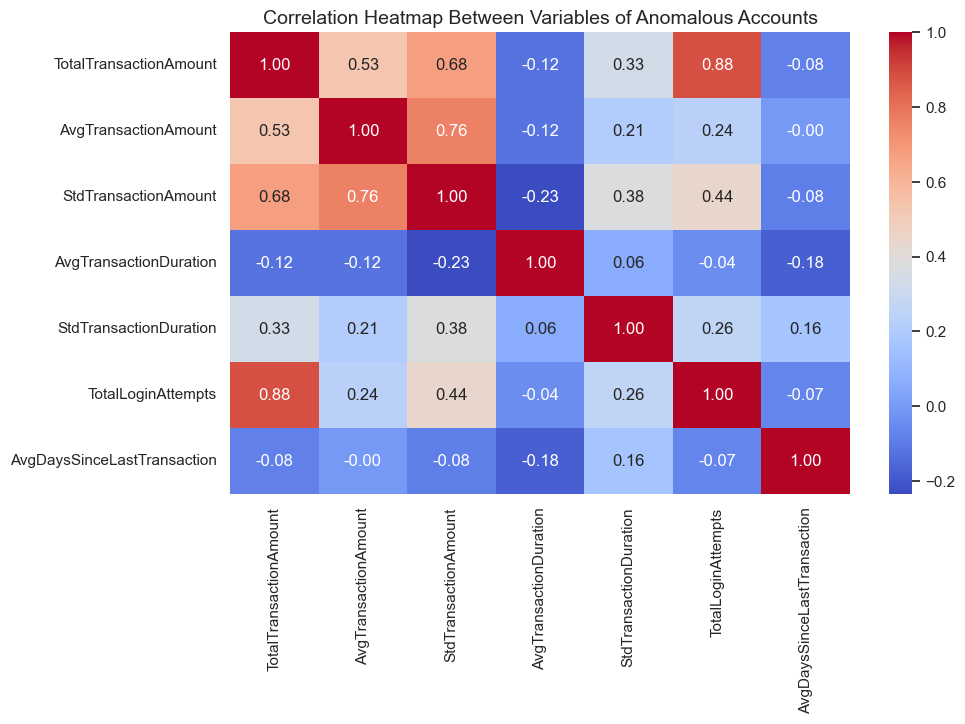

In [161]:
# Heatmap de correlación entre las variables seleccionadas
plt.figure(figsize=(10, 6))
correlation_matrix = anomalies[['TotalTransactionAmount', 'AvgTransactionAmount', 'StdTransactionAmount',
                                 'AvgTransactionDuration', 'StdTransactionDuration',
                                 'TotalLoginAttempts', 'AvgDaysSinceLastTransaction']].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
heatmap.set_title("Correlation Heatmap Between Variables of Anomalous Accounts", fontsize=14)
plt.show()

### Relación entre Duración Promedio y Desviación Estándar de Transacciones

- **Descripción**: Relaciona la duración promedio de las transacciones con su desviación estándar.
- **Interpretación**:
  - Los puntos representan cuentas.
  - El tamaño de los puntos refleja el número total de intentos de inicio de sesión.


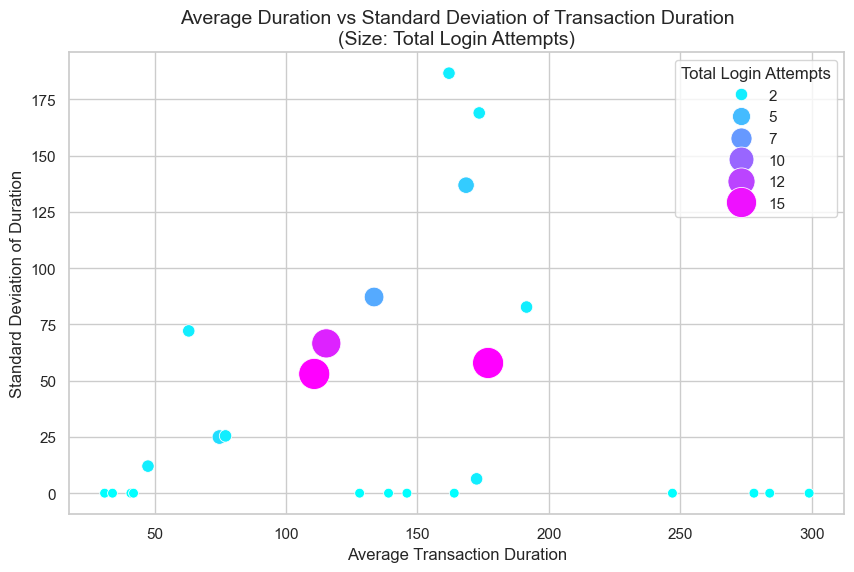

In [160]:
# Relación entre AvgTransactionDuration y StdTransactionDuration, segmentada por TotalLoginAttempts
plt.figure(figsize=(10, 6))
scatter2 = sns.scatterplot(
    data=anomalies, 
    x="AvgTransactionDuration", 
    y="StdTransactionDuration", 
    size="TotalLoginAttempts", 
    hue="TotalLoginAttempts", 
    palette="cool", 
    sizes=(50, 500), 
    legend="brief"
)
scatter2.set_title("Average Duration vs Standard Deviation of Transaction Duration\n(Size: Total Login Attempts)", fontsize=14)
scatter2.set_xlabel("Average Transaction Duration")
scatter2.set_ylabel("Standard Deviation of Duration")
plt.legend(title="Total Login Attempts")
plt.show()

# Conclusiones

- El enfoque basado en `AccountID` permite detectar patrones de comportamiento más complejos que un análisis transacción por transacción.
- Las métricas agregadas y el modelo de **Isolation Forest** destacan las cuentas con comportamiento anómalo, facilitando la detección de posibles fraudes o errores sistémicos.
- Las visualizaciones apoyan la comprensión de las relaciones entre variables y cómo se manifiestan los patrones atípicos.
- Este método es ideal para proyectos enfocados en análisis de cuentas, donde el comportamiento global es más importante que anomalías individuales.
